<a href="https://colab.research.google.com/github/sreelathask1/PES_SEM4/blob/main/Sreelatha_Optimizers_Research_with_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 337kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


OscillatingLR - Epoch [1/10], Loss: 0.5335
OscillatingLR - Epoch [2/10], Loss: 0.3188
OscillatingLR - Epoch [3/10], Loss: 0.2722
OscillatingLR - Epoch [4/10], Loss: 0.2398
OscillatingLR - Epoch [5/10], Loss: 0.2164
OscillatingLR - Epoch [6/10], Loss: 0.1981
OscillatingLR - Epoch [7/10], Loss: 0.1805
OscillatingLR - Epoch [8/10], Loss: 0.1646
OscillatingLR - Epoch [9/10], Loss: 0.1478
OscillatingLR - Epoch [10/10], Loss: 0.1326
OscillatingLR Test Accuracy: 91.84%
SGD - Epoch [1/10], Loss: 0.5267
SGD - Epoch [2/10], Loss: 0.3148
SGD - Epoch [3/10], Loss: 0.2682
SGD - Epoch [4/10], Loss: 0.2391
SGD - Epoch [5/10], Loss: 0.2163
SGD - Epoch [6/10], Loss: 0.1964
SGD - Epoch [7/10], Loss: 0.1789
SGD - Epoch [8/10], Loss: 0.1628
SGD - Epoch [9/10], Loss: 0.1483
SGD - Epoch [10/10], Loss: 0.1335
SGD Test Accuracy: 91.93%
Adam - Epoch [1/10], Loss: 0.5217
Adam - Epoch [2/10], Loss: 0.3803
Adam - Epoch [3/10], Loss: 0.3510
Adam - Epoch [4/10], Loss: 0.3397
Adam - Epoch [5/10], Loss: 0.3323
Adam -

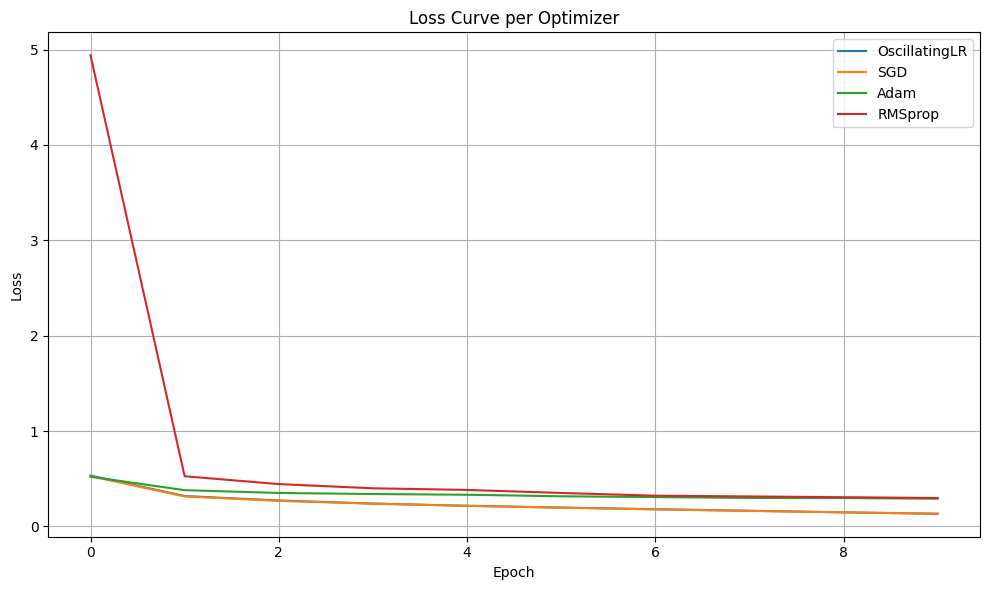


Final Accuracy Comparison:
OscillatingLR: 91.84%
SGD: 91.93%
Adam: 87.73%
RMSprop: 87.37%


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Custom Optimizer with Oscillating Learning Rate and Momentum
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005,
                 momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0

        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity

        if closure is not None:
            return closure()

# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                  transform=transform,
                                                  download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                 transform=transform,
                                                 download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN for Fashion-MNIST
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train and evaluate with loss tracking
def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = FashionMNISTCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 10
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{optimizer_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'{optimizer_name} Test Accuracy: {accuracy:.2f}%')
    return accuracy, epoch_losses

# Compare optimizers
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01,
                                      "oscillation_factor": 0.005,
                                      "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}

results = {}
loss_logs = {}

for name, (opt_class, opt_params) in optimizers.items():
    acc, losses = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = acc
    loss_logs[name] = losses

# Plot loss curves
plt.figure(figsize=(10, 6))
for name, losses in loss_logs.items():
    plt.plot(losses, label=name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve per Optimizer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final comparison
print("\nFinal Accuracy Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}%")


100%|██████████| 9.91M/9.91M [00:00<00:00, 143MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 24.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 39.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]


OscillatingLR - Epoch [1/5], Loss: 0.2092
OscillatingLR - Epoch [2/5], Loss: 0.0825
OscillatingLR - Epoch [3/5], Loss: 0.0639
OscillatingLR - Epoch [4/5], Loss: 0.0536
OscillatingLR - Epoch [5/5], Loss: 0.0470
OscillatingLR Test Accuracy: 98.27%
SGD - Epoch [1/5], Loss: 0.2027
SGD - Epoch [2/5], Loss: 0.0814
SGD - Epoch [3/5], Loss: 0.0654
SGD - Epoch [4/5], Loss: 0.0541
SGD - Epoch [5/5], Loss: 0.0476
SGD Test Accuracy: 98.10%
Adam - Epoch [1/5], Loss: 0.2333
Adam - Epoch [2/5], Loss: 0.0664
Adam - Epoch [3/5], Loss: 0.0522
Adam - Epoch [4/5], Loss: 0.0477
Adam - Epoch [5/5], Loss: 0.0416
Adam Test Accuracy: 97.86%
RMSprop - Epoch [1/5], Loss: 0.4357
RMSprop - Epoch [2/5], Loss: 0.0951
RMSprop - Epoch [3/5], Loss: 0.0585
RMSprop - Epoch [4/5], Loss: 0.0626
RMSprop - Epoch [5/5], Loss: 0.0367
RMSprop Test Accuracy: 97.76%

Final Accuracy Comparison:
OscillatingLR: 98.27%
SGD: 98.10%
Adam: 97.86%
RMSprop: 97.76%


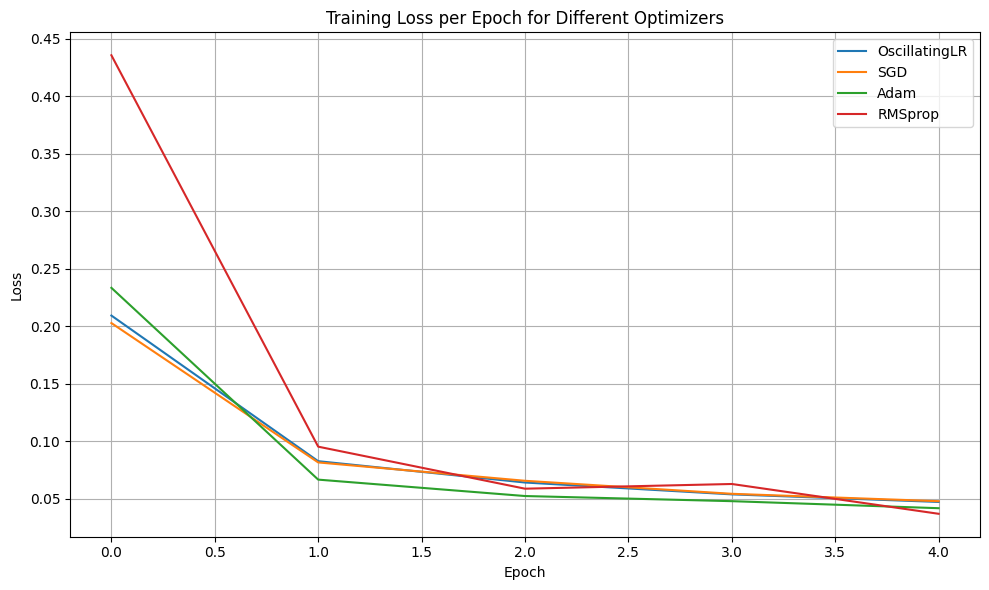

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt  # <--- Added for plotting

class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005,
                 momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0

        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity

        if closure is not None:
            return closure()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 5
    epoch_losses = []  # <--- Store losses here

    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{optimizer_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate on test data
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'{optimizer_name} Test Accuracy: {accuracy:.2f}%')
    return accuracy, epoch_losses

# Compare optimizers
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01,
                                      "oscillation_factor": 0.005}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}

results = {}
losses = {}

for name, (opt_class, opt_params) in optimizers.items():
    acc, epoch_losses = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = acc
    losses[name] = epoch_losses

# Final comparison
print("\nFinal Accuracy Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}%")

# Plot loss curves
plt.figure(figsize=(10, 6))
for name, epoch_losses in losses.items():
    plt.plot(epoch_losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch for Different Optimizers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Custom Optimizer: Oscillating Learning Rate and Momentum
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005,
                 momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count
        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity
        if closure is not None:
            return closure()

# Dataset loader
def get_dataset(name, batch_size=64):
    if name == "FashionMNIST":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
        train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                          train=True,
                                                          transform=transform,
                                                          download=True)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                         train=False,
                                                         transform=transform,
                                                         download=True)
        input_channels, num_classes = 1, 10
    elif name == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
        train_dataset = torchvision.datasets.MNIST(root='./data',
                                                   train=True,
                                                   transform=transform,
                                                   download=True)
        test_dataset = torchvision.datasets.MNIST(root='./data',
                                                  train=False,
                                                  transform=transform,
                                                  download=True)
        input_channels, num_classes = 1, 10
    elif name == "KMNIST":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
        train_dataset = torchvision.datasets.KMNIST(root='./data',
                                                    train=True,
                                                    transform=transform,
                                                    download=True)
        test_dataset = torchvision.datasets.KMNIST(root='./data',
                                                   train=False,
                                                   transform=transform,
                                                   download=True)
        input_channels, num_classes = 1, 10
    elif name == "CIFAR10":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5),
                                         (0.5,0.5,0.5))])
        train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                                     train=True,
                                                     transform=transform,
                                                     download=True)
        test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                                    train=False,
                                                    transform=transform,
                                                    download=True)
        input_channels, num_classes = 3, 10
    else:
        raise ValueError(f"Unknown dataset: {name}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False)
    return train_loader, test_loader, input_channels, num_classes

# Generic CNN
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        fc_input = 64 * 7 * 7 if in_channels == 1 else 64 * 8 * 8
        self.fc1 = nn.Linear(fc_input, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train & evaluate
def train_and_evaluate(dataset_name,
                       optimizer_name,
                       optimizer_class,
                       **optimizer_params):
    train_loader, test_loader, in_ch, num_cls = get_dataset(dataset_name)
    model = SimpleCNN(in_ch, num_cls)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"{dataset_name} | {optimizer_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'{dataset_name} | {optimizer_name} Test Accuracy: {acc:.2f}%\n')
    return acc

# Run benchmarks
datasets_to_test = ["FashionMNIST","KMNIST", "CIFAR10"]
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01,
                                      "oscillation_factor": 0.005,
                                      "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}
final_results = {}
for dataset in datasets_to_test:
    final_results[dataset] = {}
    for name, (opt_class, opt_params) in optimizers.items():
        acc = train_and_evaluate(dataset, name, opt_class, **opt_params)
        final_results[dataset][name] = acc

print("\n=== Final Accuracy Comparison Across Datasets ===")
for dataset, results in final_results.items():
    print(f"\n{dataset}:")
    for opt, acc in results.items():
        print(f"  {opt}: {acc:.2f}%")


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.21MB/s]


FashionMNIST | OscillatingLR - Epoch [1/5], Loss: 0.5335
FashionMNIST | OscillatingLR - Epoch [2/5], Loss: 0.3188
FashionMNIST | OscillatingLR - Epoch [3/5], Loss: 0.2722
FashionMNIST | OscillatingLR - Epoch [4/5], Loss: 0.2398
FashionMNIST | OscillatingLR - Epoch [5/5], Loss: 0.2164
FashionMNIST | OscillatingLR Test Accuracy: 90.38%

FashionMNIST | SGD - Epoch [1/5], Loss: 0.5359
FashionMNIST | SGD - Epoch [2/5], Loss: 0.3168
FashionMNIST | SGD - Epoch [3/5], Loss: 0.2707
FashionMNIST | SGD - Epoch [4/5], Loss: 0.2397
FashionMNIST | SGD - Epoch [5/5], Loss: 0.2192
FashionMNIST | SGD Test Accuracy: 90.68%

FashionMNIST | Adam - Epoch [1/5], Loss: 0.5934
FashionMNIST | Adam - Epoch [2/5], Loss: 0.4304
FashionMNIST | Adam - Epoch [3/5], Loss: 0.4018
FashionMNIST | Adam - Epoch [4/5], Loss: 0.3848
FashionMNIST | Adam - Epoch [5/5], Loss: 0.3798
FashionMNIST | Adam Test Accuracy: 85.10%

FashionMNIST | RMSprop - Epoch [1/5], Loss: 4.8375
FashionMNIST | RMSprop - Epoch [2/5], Loss: 0.4605
F

100%|██████████| 18.2M/18.2M [00:05<00:00, 3.55MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 327kB/s]
100%|██████████| 3.04M/3.04M [00:03<00:00, 941kB/s] 
100%|██████████| 5.12k/5.12k [00:00<00:00, 6.22MB/s]


KMNIST | OscillatingLR - Epoch [1/5], Loss: 0.3720
KMNIST | OscillatingLR - Epoch [2/5], Loss: 0.0835
KMNIST | OscillatingLR - Epoch [3/5], Loss: 0.0461
KMNIST | OscillatingLR - Epoch [4/5], Loss: 0.0287
KMNIST | OscillatingLR - Epoch [5/5], Loss: 0.0165
KMNIST | OscillatingLR Test Accuracy: 95.35%

KMNIST | SGD - Epoch [1/5], Loss: 0.3607
KMNIST | SGD - Epoch [2/5], Loss: 0.0839
KMNIST | SGD - Epoch [3/5], Loss: 0.0478
KMNIST | SGD - Epoch [4/5], Loss: 0.0290
KMNIST | SGD - Epoch [5/5], Loss: 0.0168
KMNIST | SGD Test Accuracy: 95.28%

KMNIST | Adam - Epoch [1/5], Loss: 0.4508
KMNIST | Adam - Epoch [2/5], Loss: 0.2549
KMNIST | Adam - Epoch [3/5], Loss: 0.2196
KMNIST | Adam - Epoch [4/5], Loss: 0.2020
KMNIST | Adam - Epoch [5/5], Loss: 0.1881
KMNIST | Adam Test Accuracy: 86.32%

KMNIST | RMSprop - Epoch [1/5], Loss: 9.0573
KMNIST | RMSprop - Epoch [2/5], Loss: 0.1875
KMNIST | RMSprop - Epoch [3/5], Loss: 0.1350
KMNIST | RMSprop - Epoch [4/5], Loss: 0.1105
KMNIST | RMSprop - Epoch [5/5],

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


CIFAR10 | OscillatingLR - Epoch [1/5], Loss: 1.5422
CIFAR10 | OscillatingLR - Epoch [2/5], Loss: 1.0778
CIFAR10 | OscillatingLR - Epoch [3/5], Loss: 0.8815
CIFAR10 | OscillatingLR - Epoch [4/5], Loss: 0.7376
CIFAR10 | OscillatingLR - Epoch [5/5], Loss: 0.6110
CIFAR10 | OscillatingLR Test Accuracy: 72.16%

CIFAR10 | SGD - Epoch [1/5], Loss: 1.5199
CIFAR10 | SGD - Epoch [2/5], Loss: 1.0546
CIFAR10 | SGD - Epoch [3/5], Loss: 0.8574
CIFAR10 | SGD - Epoch [4/5], Loss: 0.7073
CIFAR10 | SGD - Epoch [5/5], Loss: 0.5734
CIFAR10 | SGD Test Accuracy: 72.01%

